In [11]:
!pip install bert-for-tf2

In [12]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import pickle

from bert import bert_tokenization


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [13]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/1",
                            trainable=True)

In [14]:
train_data, test_data = tfds.load(name="civil_comments", split=["train", "test"], data_dir="/content/drive/My Drive/AD/civil_comments", batch_size=-1, as_supervised=True)



In [68]:
train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

In [37]:
not_all_positive_comments_positions = np.argwhere(train_labels == 0)[:5000, 0]
negative_comments_positions = np.argwhere(train_labels == 1)[:,0]

In [39]:
train_examples[not_all_positive_comments_positions][0]

TypeError: ignored

In [30]:
train_data = pickle.load( open( "/content/drive/My Drive/AD/train_dataset.pickle", "rb" ) )
test_data = pickle.load( open( "/content/drive/My Drive/AD/test_dataset.pickle", "rb" ) )
train_examples = pickle.load( open( "/content/drive/My Drive/AD/train_examples.pickle", "rb" ) )
test_examples = pickle.load( open( "/content/drive/My Drive/AD/test_examples.pickle", "rb" ) )

In [40]:
ex = np.array(train_examples)


721


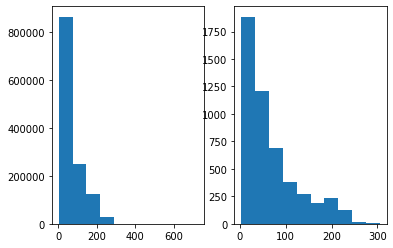

In [67]:
res = list ( map(len,  ex[np.argwhere( train_labels == 0)[:,0]] ) )
sec = list ( map(len,  ex[not_all_positive_comments_positions] ) )
print ( max(res))
plt.subplot(1,2, 1)
plt.hist(res)
plt.subplot(1,2, 2)
plt.hist(sec)
plt.show()



272


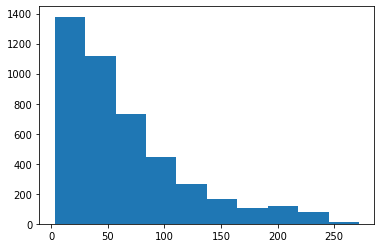

In [53]:
import matplotlib.pyplot as plt


resolt = list( map(len, ex[negative_comments_positions] ) )
print(max(resolt))
plt.hist(resolt )
plt.show()

In [32]:
map(  )

53

In [28]:
bert_layer1 = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)

vocab_file = bert_layer1.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer1.resolved_object.do_lower_case.numpy()


tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

def tokenize_text(txt):
    tokenized_txt = tokenizer.tokenize(txt)
    tokenized_txt = ["[CLS]"] + tokenized_txt + ["[SEP]"]
    tokenized_txt = tokenizer.convert_tokens_to_ids(tokenized_txt)
    return tokenized_txt


In [29]:

train_examples = list(map(tokenize_text, train_examples))
test_examples = list(map(tokenize_text, test_examples))

KeyboardInterrupt: ignored

In [ ]:
import gc

train_labels = tfds.as_numpy(train_data)[1]
test_labels = tfds.as_numpy(test_data)[1]
del train_data
del test_data
gc.collect()

2215

In [ ]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(train_examples, maxlen=100, padding='post')

max_seq_length = x_train.shape[1]
x_test = tf.keras.preprocessing.sequence.pad_sequences(test_examples, maxlen=100, padding='post', truncating='post')

train_mask = (x_train != 0).astype(int)
test_mask = (x_test != 0).astype(int)

train_segments = np.zeros(x_train.shape)
test_segments = np.zeros(x_test.shape)

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

bert_inputs = [input_word_ids, input_mask, segment_ids]
pooled_output, sequence_output = bert_layer(bert_inputs)

final_layer = tf.keras.layers.Dense(1)
final_output = final_layer(pooled_output)

In [ ]:
checkpoint_filepath = '/content/drive/My Drive/AD/checkpoint2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,

    save_freq = 1000)


In [ ]:
model = tf.keras.models.Model(inputs=bert_inputs, outputs=final_output)

In [ ]:
model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(),
              optimizer=tf.optimizers.Adam(learning_rate=1e-4), 
              metrics=["accuracy"])

In [ ]:
model.fit([x_train, train_mask, train_segments], train_labels, epochs=1, batch_size=32,
          validation_data=([x_test, test_mask, test_segments], test_labels))

 1152/56403 [..............................] - ETA: 18:03:42 - loss: 0.0414 - accuracy: 0.6954

KeyboardInterrupt: ignored

In [ ]:
model([text, mask, segments])

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.11848545],
       [0.1188764 ],
       [0.11862588],
       [0.11919081]], dtype=float32)>

In [ ]:
m = tf.keras.models.load_model('/content/drive/My Drive/AD/checkpoint'
)


In [ ]:
import pandas as pd

text = pd.read_csv("notI.csv", names=["sentance"], index_col=False)
text = text.to_numpy()

print (text[:,0].tolist())
text = text[:,0].tolist()
text = list(map(tokenize_text, text))
text = tf.keras.preprocessing.sequence.pad_sequences(text, maxlen=100, padding='post')
mask = (text != 0).astype(int)
segments = np.zeros(text.shape)


['temporrytext that is absoulutlely not important', 'anotehre aboulutally not important text', 'you are ugly so ugly', 'hate speech']


In [ ]:


# print (text)
resoult = m([text, mask, segments])
print(resoult)

tf.Tensor(
[[0.18121138]
 [0.18121138]
 [0.18121138]
 [0.18121138]], shape=(4, 1), dtype=float32)
